### Import modules

In [1]:
import pickle
import pandas as pd
import numpy as np
import pymysql.cursors
import sys
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

### Connect to database and preview the dataframe

In [2]:
URI = "database-test1.ckvmcnbipeqn.eu-west-1.rds.amazonaws.com"
PORT = 3306
DB = "dbbikes"
USER = "picto"
PASSWORD = "Comp30830"
try:
    conn = pymysql.connect(host=URI, user=USER, password=PASSWORD, port=PORT, database=DB)

    cursor = conn.cursor()
    sql = "SELECT * FROM db_bikes.station_new_availability"
    cursor.execute(sql)
    results = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    df_bikes_availability = pd.DataFrame(results, columns= columns)
    print("Database connected successfully")
except Exception as e:
    sys.exit(e)

df_bikes_availability.tail()

### Add columns

In [ ]:
df_bikes_availability['weekday'] = df_bikes_availability.last_update.dt.day_name()
df_bikes_availability.loc[df_bikes_availability.last_update >= pd.Timestamp('2023-03-26 01:00:00'), 'hour'] = df_bikes_availability.last_update.dt.hour + 1
df_bikes_availability.loc[df_bikes_availability.last_update < pd.Timestamp('2023-03-26 01:00:00'), 'hour'] = df_bikes_availability.last_update.dt.hour
df_bikes_availability.loc[df_bikes_availability['hour'] == 24.0, 'hour'] = 0.0
df_bikes_availability['total_stands'] = df_bikes_availability['available_bikes'] + df_bikes_availability['available_bike_stands']

In [ ]:
df_bikes_availability.tail()

,number,available_bikes,available_bike_stands,last_update,weekday,hour,total_stands
1181035,39,11,9,2023-04-18 21:25:30,Tuesday,22.0,20
1181036,83,28,12,2023-04-18 21:19:47,Tuesday,22.0,40
1181037,92,40,0,2023-04-18 21:27:51,Tuesday,22.0,40
1181038,21,4,26,2023-04-18 21:25:24,Tuesday,22.0,30
1181039,88,21,9,2023-04-18 21:27:10,Tuesday,22.0,30


### Check null data

In [ ]:
df_bikes_availability[df_bikes_availability.isnull().values==True]

,number,available_bikes,available_bike_stands,last_update,weekday,hour,total_stands


### descriptive statistics

In [ ]:
# check all of the data types
print(df_bikes_availability.dtypes)

number                            int64
available_bikes                   int64
available_bike_stands             int64
last_update              datetime64[ns]
weekday                          object
hour                            float64
total_stands                      int64
dtype: object


In [ ]:
# modify the data type of weekday to category
df_bikes_availability['weekday'] = df_bikes_availability['weekday'].astype('category')
df_bikes_availability.select_dtypes(['category']).describe().T

,count,unique,top,freq
weekday,1181040,7,Tuesday,187852


In [ ]:
numeric_columns = df_bikes_availability.select_dtypes(['int64']).columns
df_bikes_availability[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
number,1181040.0,58.824561,34.115465,1.0,29.0,58.5,89.0,117.0
available_bikes,1181040.0,11.421385,9.469794,0.0,3.0,10.0,17.0,40.0
available_bike_stands,1181040.0,20.116347,10.954976,0.0,12.0,20.0,29.0,40.0
total_stands,1181040.0,31.537732,8.012790,0.0,29.0,30.0,40.0,40.0


In [ ]:
df_bikes_availability.select_dtypes(['datetime64[ns]']).describe().T

D:\temp\ipykernel_20528\4187618595.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_bikes_availability.select_dtypes(['datetime64[ns]']).describe().T


,count,unique,top,freq,first,last
last_update,1181040,581946,2023-03-26 00:50:25,434,2023-03-13 14:37:42,2023-04-18 21:28:47


### plot

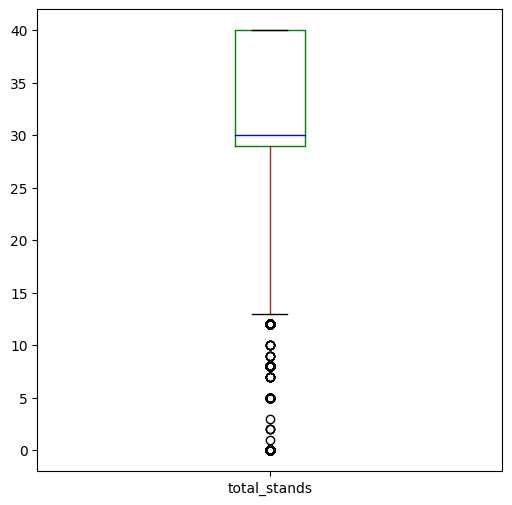

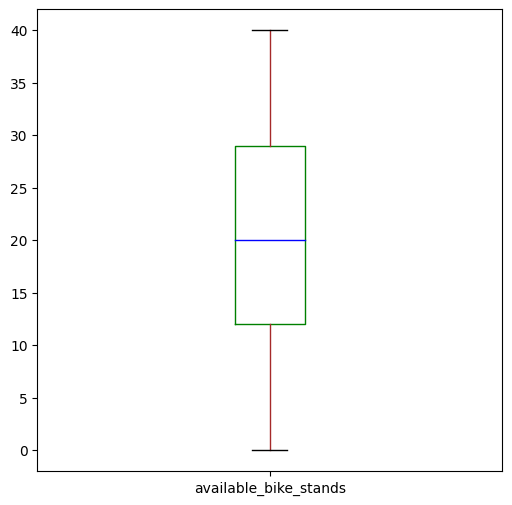

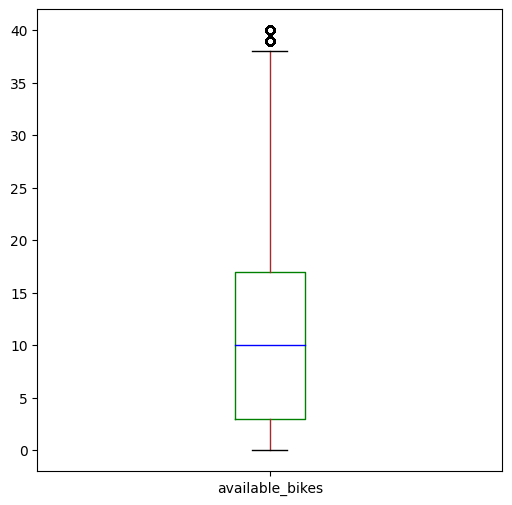

In [ ]:
station_info = {'available_bikes','available_bike_stands', 'total_stands'}
color = {'boxes': 'Green', 'whiskers': 'Brown', 'medians': 'Blue', 'caps': 'Black'}

for col in station_info:
    f = df_bikes_availability[col].plot(color=color, kind='box', figsize=(6, 6))
    plt.show()

array([[<AxesSubplot:title={'center':'total_stands'}>,
        <AxesSubplot:title={'center':'available_bike_stands'}>],
       [<AxesSubplot:title={'center':'available_bikes'}>, <AxesSubplot:>]],
      dtype=object)

<Figure size 640x480 with 0 Axes>

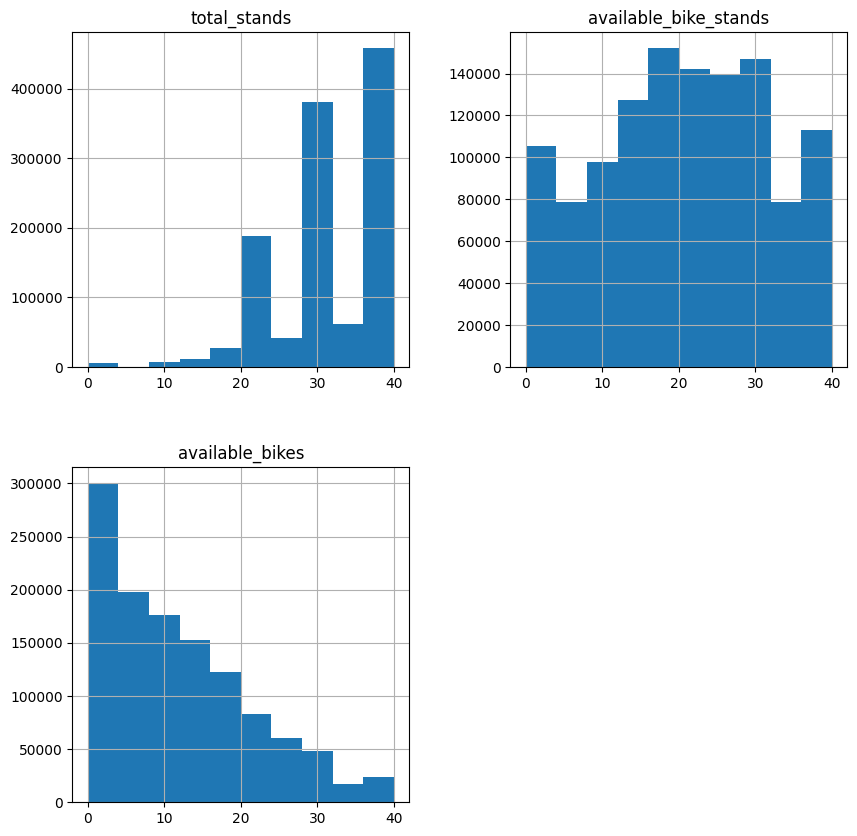

In [ ]:
plt.figure()
df_bikes_availability[list(station_info)].hist(figsize=(10, 10))

<AxesSubplot:xlabel='available_bikes', ylabel='available_bike_stands'>

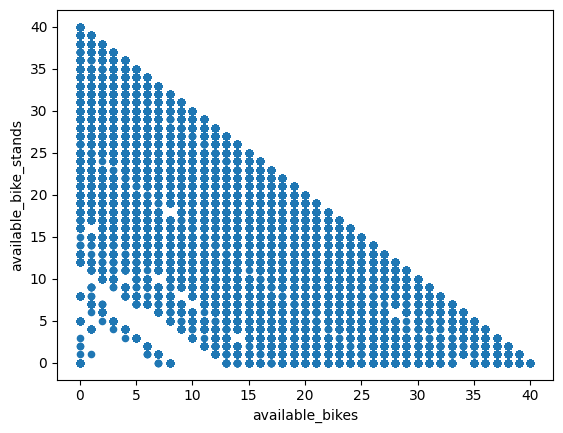

In [ ]:
df_bikes_availability.plot(kind='scatter', x='available_bikes', y='available_bike_stands')

<AxesSubplot:>

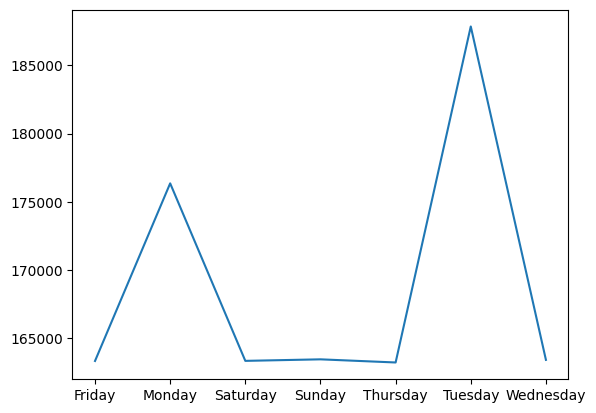

In [ ]:
df_bikes_availability.weekday.value_counts().sort_index().plot()

### store the fixed station stands

In [ ]:
df_station = pd.DataFrame(df_bikes_availability, columns=['number', 'total_stands'])
df_station = df_station.drop_duplicates(['number'])
df_station = df_station.reset_index().drop('index',axis=1)
df_station = df_station.sort_values(['number'], ascending=[True])
df_station

,number,total_stands
16,1,31
83,2,20
104,3,20
44,4,20
39,5,40
...,...,...
31,113,40
28,114,40
56,115,30
36,116,30


In [ ]:
df_station['total_stands'][df_bikes_availability['number'] == 2].iloc[0]

20

In [ ]:
station_total_stands = dict()
for ID in df_station['number']:
    station_total_stands[ID] = df_station['total_stands'][df_station['number'] == ID].iloc[0]
print(station_total_stands)

{1: 31, 2: 20, 3: 20, 4: 20, 5: 40, 6: 20, 7: 29, 8: 30, 9: 24, 10: 16, 11: 30, 12: 20, 13: 30, 14: 30, 15: 13, 16: 20, 17: 20, 18: 30, 19: 30, 20: 30, 21: 30, 22: 19, 23: 30, 24: 20, 25: 30, 26: 20, 27: 20, 28: 30, 29: 29, 30: 20, 31: 20, 32: 30, 33: 23, 34: 30, 35: 29, 36: 40, 37: 30, 38: 40, 39: 20, 40: 21, 41: 20, 42: 30, 43: 30, 44: 30, 45: 30, 47: 40, 48: 40, 49: 40, 50: 40, 51: 40, 52: 32, 53: 40, 54: 33, 55: 34, 56: 40, 57: 23, 58: 40, 59: 20, 60: 30, 61: 25, 62: 40, 63: 35, 64: 40, 65: 40, 66: 40, 67: 40, 68: 40, 69: 40, 71: 40, 72: 31, 73: 30, 74: 30, 75: 40, 76: 38, 77: 29, 78: 40, 79: 27, 80: 40, 82: 8, 83: 40, 84: 30, 85: 35, 86: 38, 87: 38, 88: 30, 89: 40, 90: 40, 91: 30, 92: 40, 93: 40, 94: 40, 95: 40, 96: 30, 97: 40, 98: 40, 99: 30, 100: 25, 101: 30, 102: 40, 103: 40, 104: 40, 105: 36, 106: 40, 107: 40, 108: 35, 109: 29, 110: 40, 111: 40, 112: 30, 113: 40, 114: 40, 115: 30, 116: 30, 117: 39}


In [ ]:
# descriptive statistic of station data
df_station.describe().T

,count,mean,std,min,25%,50%,75%,max
number,114.0,58.824561,34.266071,1.0,29.25,58.5,88.75,117.0
total_stands,114.0,31.789474,7.824936,8.0,29.00,30.0,40.00,40.0


In [ ]:
len(station_total_stands)

114

### save the data into csv

In [ ]:
df_bikes_availability.to_csv('df_bikes_availability.csv',index=None)

In [ ]:
df_station.to_csv('df_station.csv',index=None)

### weather data

In [ ]:
URI = "database-test1.ckvmcnbipeqn.eu-west-1.rds.amazonaws.com"
PORT = 3306
DB = "dbbikes"
USER = "picto"
PASSWORD = "Comp30830"
try:
    conn = pymysql.connect(host=URI, user=USER, password=PASSWORD, port=PORT, database=DB)
    sql = "SELECT * FROM db_bikes.dublin_new_weather"
    cursor.execute(sql)
    results = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    df_curr_weather = pd.DataFrame(results, columns= columns)
    print("Database connected successfully")
except Exception as e:
    sys.exit(e)

df_curr_weather.tail()

Database connected successfully


,dt,sunrise,sunset,temp,feels_like,pressure,humidity,uvi,clouds,visibility,wind_speed,wind_deg,weather_description,temp_min,temp_max
9591,2023-04-18 21:06:13,2023-04-18 05:19:23,2023-04-18 19:29:07,283.24,282.37,1029,79,0.0,20,10000,6.17,70,few clouds,282.69,285.08
9592,2023-04-18 21:11:13,2023-04-18 05:19:23,2023-04-18 19:29:07,283.24,282.37,1029,79,0.0,20,10000,6.17,70,few clouds,282.69,285.08
9593,2023-04-18 21:16:13,2023-04-18 05:19:23,2023-04-18 19:29:07,283.20,282.32,1029,79,0.0,20,10000,7.20,70,few clouds,282.69,285.08
9594,2023-04-18 21:21:13,2023-04-18 05:19:23,2023-04-18 19:29:07,282.94,279.76,1028,81,0.0,20,10000,7.20,70,few clouds,282.67,285.08
9595,2023-04-18 21:26:13,2023-04-18 05:19:23,2023-04-18 19:29:07,282.94,279.76,1028,81,0.0,20,10000,7.20,70,few clouds,282.67,285.08


In [ ]:
df_curr_weather = df_curr_weather[['dt','temp','clouds','wind_speed','weather_description','pressure','humidity']]

In [ ]:
df_curr_weather.dtypes

dt                     datetime64[ns]
temp                          float64
clouds                          int64
wind_speed                    float64
weather_description            object
pressure                        int64
humidity                        int64
dtype: object

In [ ]:
df_curr_weather['weather_description'] = df_curr_weather['weather_description'].astype('category')


In [ ]:
df_curr_weather.dtypes

dt                     datetime64[ns]
temp                          float64
clouds                          int64
wind_speed                    float64
weather_description          category
pressure                        int64
humidity                        int64
dtype: object

In [ ]:
df_curr_weather[df_curr_weather.isnull().values==True]

,dt,temp,clouds,wind_speed,weather_description,pressure,humidity


In [ ]:
duplicate = df_curr_weather[df_curr_weather.duplicated(keep=False)].shape[0]
print("There are {} duplicate rows including the first row.".format(duplicate))

There are 0 duplicate rows including the first row.


In [ ]:
df_curr_weather.to_csv('df_curr_weather.csv', index=None)

#### Merge availability and weather dataframe

In [ ]:
df_bikes_availability_sorted = df_bikes_availability.sort_values(by=['last_update'])
df_curr_weather_sorted = df_curr_weather.sort_values(by=['dt'])
df_merged = pd.merge_asof(df_bikes_availability_sorted,df_curr_weather_sorted,left_on='last_update',right_on='dt')
df_merged.tail()

,number,available_bikes,available_bike_stands,last_update,weekday,hour,total_stands,dt,temp,clouds,wind_speed,weather_description,pressure,humidity
1181035,7,2,27,2023-04-18 21:28:33,Tuesday,22.0,29,2023-04-18 21:26:13,282.94,20.0,7.2,few clouds,1028.0,81.0
1181036,27,0,20,2023-04-18 21:28:41,Tuesday,22.0,20,2023-04-18 21:26:13,282.94,20.0,7.2,few clouds,1028.0,81.0
1181037,29,13,16,2023-04-18 21:28:42,Tuesday,22.0,29,2023-04-18 21:26:13,282.94,20.0,7.2,few clouds,1028.0,81.0
1181038,76,12,26,2023-04-18 21:28:44,Tuesday,22.0,38,2023-04-18 21:26:13,282.94,20.0,7.2,few clouds,1028.0,81.0
1181039,35,14,15,2023-04-18 21:28:47,Tuesday,22.0,29,2023-04-18 21:26:13,282.94,20.0,7.2,few clouds,1028.0,81.0


In [ ]:
df_merged[df_merged.isnull().values==True]

,number,available_bikes,available_bike_stands,last_update,weekday,hour,total_stands,dt,temp,clouds,wind_speed,weather_description,pressure,humidity
0,8,4,26,2023-03-13 14:37:42,Monday,14.0,30,NaT,NaN,NaN,NaN,NaN,NaN,NaN
0,8,4,26,2023-03-13 14:37:42,Monday,14.0,30,NaT,NaN,NaN,NaN,NaN,NaN,NaN
0,8,4,26,2023-03-13 14:37:42,Monday,14.0,30,NaT,NaN,NaN,NaN,NaN,NaN,NaN
0,8,4,26,2023-03-13 14:37:42,Monday,14.0,30,NaT,NaN,NaN,NaN,NaN,NaN,NaN
0,8,4,26,2023-03-13 14:37:42,Monday,14.0,30,NaT,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,88,12,18,2023-03-13 15:17:59,Monday,15.0,30,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1203,88,12,18,2023-03-13 15:17:59,Monday,15.0,30,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1203,88,12,18,2023-03-13 15:17:59,Monday,15.0,30,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1203,88,12,18,2023-03-13 15:17:59,Monday,15.0,30,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_merged.dropna(axis=0,how='any',inplace=True)

In [ ]:
df_merged = df_merged.drop(columns=['total_stands'])

In [ ]:
df_merged.dtypes

number                            int64
available_bikes                   int64
available_bike_stands             int64
last_update              datetime64[ns]
weekday                        category
hour                            float64
dt                       datetime64[ns]
temp                            float64
clouds                          float64
wind_speed                      float64
weather_description            category
pressure                        float64
humidity                        float64
dtype: object

In [ ]:
df_merged.to_csv('df_merged.csv',index=True)

In [ ]:
features = df_merged.columns.values.tolist()
features

['number',
 'available_bikes',
 'available_bike_stands',
 'last_update',
 'weekday',
 'hour',
 'dt',
 'temp',
 'clouds',
 'wind_speed',
 'weather_description',
 'pressure',
 'humidity']

In [ ]:
features_dict = dict()
for ID in df_merged['number'].unique():
    df_model = df_merged[df_merged['number']==ID].copy().drop('last_update',axis=1)
    df_model = df_model.drop('number',axis=1)
    df_model = df_model.reset_index().drop('index',axis=1)
    df_model = pd.get_dummies(df_model,drop_first=False)
    features_dict[ID] = df_model
features_dict

{39:        available_bikes  available_bike_stands  hour                  dt  \
 0                   12                      8  15.0 2023-03-13 15:18:07   
 1                   12                      8  15.0 2023-03-13 15:18:07   
 2                   12                      8  15.0 2023-03-13 15:26:19   
 3                   12                      8  15.0 2023-03-13 15:26:19   
 4                   12                      8  15.0 2023-03-13 15:36:19   
 ...                ...                    ...   ...                 ...   
 10345                9                     11  22.0 2023-04-18 21:01:13   
 10346               11                      9  22.0 2023-04-18 21:06:13   
 10347               10                     10  22.0 2023-04-18 21:16:13   
 10348               10                     10  22.0 2023-04-18 21:16:13   
 10349               11                      9  22.0 2023-04-18 21:21:13   
 
          temp  clouds  wind_speed  pressure  humidity  weekday_Friday  ...  \
 0 

In [ ]:
models = dict()
model_features = ['weekday_Sunday','weekday_Monday','weekday_Tuesday','weekday_Wednesday','weekday_Thursday','weekday_Friday','weekday_Saturday','hour','temp','clouds','wind_speed','pressure','humidity']

for ID in features_dict:
    input_model = features_dict[ID][model_features]
    output = features_dict[ID]['available_bikes']
    print("=======Training the station: %s=======" % ID)
    X_train,X_test,Y_train,Y_test=train_test_split(input_model.values,output.values,test_size=0.33,random_state=0)
    print("=======Training the model on %s rows and %s columns=======" % X_train.shape)
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_train, Y_train)
    print("Testing the model on %s rows." % Y_test.shape[0])
    
    models[ID] = rf.fit(X_train, Y_train)

=======Training the station: 39=======
=======Training the model on 6934 rows and 13 columns=======
Testing the model on 3416 rows.
=======Training the station: 24=======
=======Training the model on 6934 rows and 13 columns=======
Testing the model on 3416 rows.
=======Training the station: 25=======
=======Training the model on 6934 rows and 13 columns=======
Testing the model on 3416 rows.
=======Training the station: 62=======
=======Training the model on 6934 rows and 13 columns=======
Testing the model on 3416 rows.
=======Training the station: 87=======
=======Training the model on 6934 rows and 13 columns=======
Testing the model on 3416 rows.
=======Training the station: 75=======
=======Training the model on 6934 rows and 13 columns=======
Testing the model on 3416 rows.
=======Training the station: 21=======
=======Training the model on 6934 rows and 13 columns=======
Testing the model on 3416 rows.
=======Training the station: 66=======
=======Training the model on 6934 row

In [ ]:
input_model.head()

,weekday_Sunday,weekday_Monday,weekday_Tuesday,weekday_Wednesday,weekday_Thursday,weekday_Friday,weekday_Saturday,hour,temp,clouds,wind_speed,pressure,humidity
0,0,1,0,0,0,0,0,15.0,282.85,75.0,5.66,981.0,89.0
1,0,1,0,0,0,0,0,15.0,282.85,75.0,5.66,981.0,89.0
2,0,1,0,0,0,0,0,15.0,282.85,75.0,5.66,981.0,89.0
3,0,1,0,0,0,0,0,15.0,282.83,75.0,5.66,981.0,89.0
4,0,1,0,0,0,0,0,15.0,282.83,75.0,5.66,981.0,89.0


In [ ]:
for ID in features_dict:
    x = features_dict[ID][model_features]  
    y = features_dict[ID]['available_bikes']
    predict_vals = models[ID].predict(x.values)
    
    print("\nPredictions with Random Forest regression: \n")
    actu_pred_vals = pd.concat([y, pd.DataFrame(predict_vals, columns=['Predicted'])], axis=1)
    print(actu_pred_vals)


Predictions with Random Forest regression: 

       available_bikes  Predicted
0                   12  12.000000
1                   12  12.000000
2                   12  12.000000
3                   12  12.000000
4                   12  12.522167
...                ...        ...
10345                9   9.540000
10346               11   9.670000
10347               10   9.756333
10348               10   9.756333
10349               11   9.166333

[10350 rows x 2 columns]

Predictions with Random Forest regression: 

       available_bikes  Predicted
0                    2   1.920000
1                    2   1.920000
2                    2   1.920000
3                    1   1.040000
4                    1   1.040000
...                ...        ...
10345               19  18.724833
10346               20  18.724833
10347               18  17.637500
10348               17  17.637500
10349               16  17.795000

[10350 rows x 2 columns]

Predictions with Random Forest regressi

In [ ]:
def model_evaluation(actu_vals, pred_vals):
    #classification evaluation measures
    print("MAE: ", metrics.mean_absolute_error(actu_vals, pred_vals))
    print("MSE: ", metrics.mean_squared_error(actu_vals, pred_vals))
    print("RMSE: ", metrics.mean_squared_error(actu_vals, pred_vals)**0.5)
    print("R2: ", metrics.r2_score(actu_vals, pred_vals))
    print("\n")

In [ ]:
RMSEs = []
R2 = []
X_train_size_avg = 0
X_test_size_avg = 0

for ID in features_dict:
    X = features_dict[ID][model_features]
    Y = features_dict[ID]['available_bikes']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    
    X_train_size_avg += X_train.shape[0]/len(features_dict)
    X_test_size_avg += X_test.shape[0]/len(features_dict)
    prediction = models[ID].predict(X_test.values)
    print("=======Station: %s =======\n" % ID)
    model_evaluation(y_test, prediction)
    
    RMSEs += [metrics.mean_squared_error(y_test, prediction)**0.5]
    R2 += [metrics.r2_score(y_test, prediction)]

=======Station: 39 =======

MAE:  0.5150191636579864
MSE:  0.7906163045082899
RMSE:  0.8891660725130541
R2:  0.9669623346846162


=======Station: 24 =======

MAE:  0.6237453705208226
MSE:  1.1684625273414178
RMSE:  1.0809544520197962
R2:  0.9673623189249491


=======Station: 25 =======

MAE:  0.30922923196922586
MSE:  0.37632753236779337
RMSE:  0.6134554037318388
R2:  0.9928218422597986


=======Station: 62 =======

MAE:  0.3803875367152984
MSE:  0.5253637555958746
RMSE:  0.7248198090531706
R2:  0.9869056712870931


=======Station: 87 =======

MAE:  0.3528213399459058
MSE:  0.6434422851265617
RMSE:  0.8021485430558118
R2:  0.9890069695460011


=======Station: 75 =======

MAE:  0.4995138435674682
MSE:  0.9309624634075941
RMSE:  0.9648639610886056
R2:  0.9876829287771196


=======Station: 21 =======

MAE:  0.6137906296816387
MSE:  1.4653978633420817
RMSE:  1.2105361883653383
R2:  0.9799769147949755


=======Station: 66 =======

MAE:  0.7945770616962265
MSE:  2.2893667595982783
RMSE:  1.5

In [ ]:
print('Avgerage train/test size: %.0f/%.0f'%(X_train_size_avg,X_test_size_avg))
print("The minimum RMSE of all prediction models is: %f" %min(RMSEs))
print("The maximum RMSE of all prediction models is: %f" %max(RMSEs))
print("The minimum R2 of all pprediction models is: %f" %min(R2))
print("The maximum R2 of all prediction models is: %f" %max(R2))

Avgerage train/test size: 7244/3105
The minimum RMSE of all predition models is: 0.347395
The maximum RMSE of all predition models is: 2.223068
The minimum R2 of all predition models is: 0.930103
The maximum R2 of all predition models is: 0.994160


In [ ]:
for ID in models:
    with open('model_'+str(ID)+'.pkl','wb') as handle:
        pickle.dump(models[ID], handle, pickle.HIGHEST_PROTOCOL)

In [ ]:
conn.close()